In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from utils import *

pd.set_option('display.max_columns', 150)
pd.options.mode.chained_assignment = None  # default='warn'

In [14]:
path = 'data/'
data = pd.read_csv(path + 'preprocessed_data2.csv')
print(data.shape)

(372, 66)


In [15]:
# X, y = get_data(data)

X = data[data.columns.difference(['id','excluido','VTE'])]
y = data['VTE']
X.shape, y.shape

((372, 63), (372,))

In [16]:
X.head()

,Family,bmi_normal,bmi_obese,bmi_overweight,bmi_underweight,cateter,cirugiaPrev,diabetesM,dislip,edatDx,estadiGrup_I,estadiGrup_II,estadiGrup_III,estadiGrup_IV,etnia_caucasica,etnia_hispanoamericana,etnia_negra,etnia_otra,fumador_activo,fumador_exfumador,fumador_nunca,hemoglobina,hta_desc,khorana,leucocits,plaquetes,psIniQT_desc,rs1039084,rs1063856,rs11696364,rs118203906,rs1208134,rs121909548,rs1613662,rs16861990,rs169713,rs1799963,rs1801020,rs1883888,rs2036914,rs2227589,rs2232698,rs268,rs3087505,rs4149755,rs4524,rs45454293,rs5985,rs6025,rs6034465,rs7853989,rs8176719,rs8176749,rs8176750,rs9332695,rs9363864,sexe_hombre,sexe_mujer,tipusTumor_colon,tipusTumor_esofago,tipusTumor_estomago,tipusTumor_pancreas,tipusTumor_pulmon
0,0,1,0,0,0,0,0,0,1,78,0,0,0,1,1,0,0,0,0,1,0,12.7,1,2.0,6800,169000,1,2,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,1,0,0,1,0,0,0,50,0,0,0,1,1,0,0,0,1,0,0,13.0,0,2.0,10900,203000,1,0,2,2,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,2,0,0,1,2,1,0,0,1,0,0,0
2,0,1,0,0,0,1,1,0,1,68,0,0,0,1,1,0,0,0,1,0,0,12.4,1,1.0,7700,194000,1,1,2,0,0,0,0,1,0,1,0,1,2,1,1,0,0,0,0,2,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1
3,0,1,0,0,0,1,0,1,1,71,0,0,0,1,1,0,0,0,1,0,0,10.4,1,0.0,8600,284000,1,1,2,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,0
4,0,0,0,1,0,1,0,0,0,59,0,0,0,1,1,0,0,0,0,1,0,12.3,1,0.0,8800,254000,1,2,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,1,0,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0


In [17]:
y.value_counts()

0    301
1     71
Name: VTE, dtype: int64

In [9]:
# check outliers
# import seaborn as sns

# sns.boxplot(X['leucocits'])

In [18]:
from sklearn.model_selection import train_test_split

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1621)
print(X_train.shape, X_test.shape)

(279, 63) (93, 63)


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [27]:
SEED = 1135
class_weight = {1:20}

base_models = [
          ('LR', LogisticRegression(solver='liblinear', max_iter=1000, random_state=SEED)), 
          ('RF', RandomForestClassifier(n_estimators=80, random_state=SEED, class_weight=class_weight)),
          ('KNN', KNeighborsClassifier(n_neighbors=5)),
          ('CART', DecisionTreeClassifier(class_weight=class_weight)),
          ('SVM', SVC(probability=True, random_state=SEED, class_weight=class_weight)), 
          ('AB', AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('ET', ExtraTreesClassifier(class_weight=class_weight)),
          ('LGB', LGBMClassifier(class_weight=class_weight, random_state=SEED)),
#           ('XGB', XGBClassifier(random_state=SEED))
        ]

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_name = 'standard'
  
if scaler_name == 'standard':
    scaler = StandardScaler()
elif scaler_name =='minmax':
    scaler = MinMaxScaler()

pipelines = []
for name, model in base_models:
  pipelines.append((name  , Pipeline([('Scaler', scaler),(name,model)])))

In [29]:
final = run_exps(pipelines, X_train, y_train)
bootstrap_df, results = results_bootstrap(final)

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


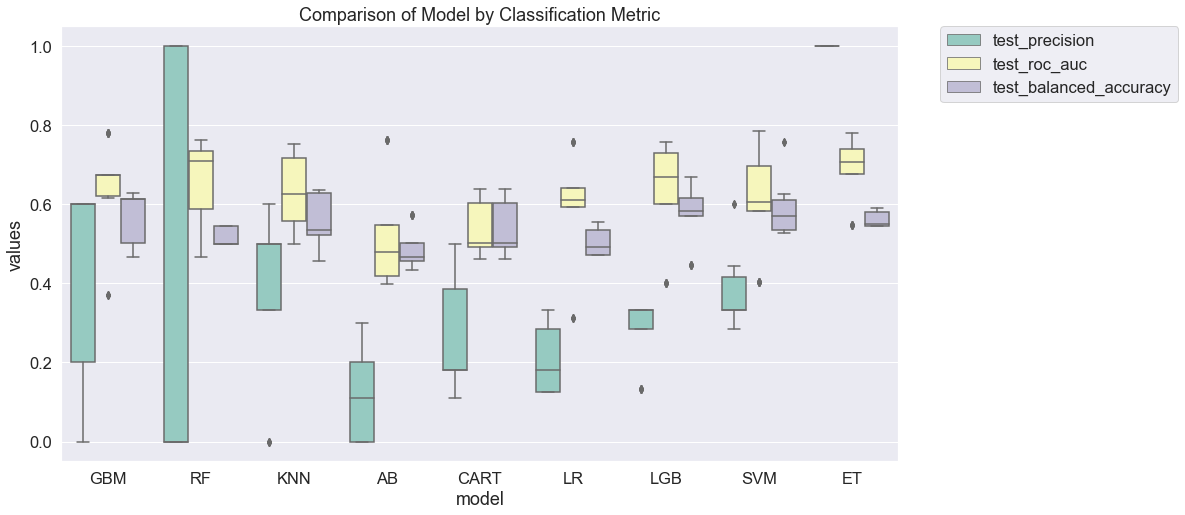

In [30]:
plot_performances(results)

In [31]:
tabulate_results(bootstrap_df, results)

test_precision           test_balanced_accuracy           test_roc_auc  \
                mean       std                   mean       std         mean   
model                                                                          
AB          0.118889  0.118129               0.486544  0.050402     0.524225   
CART        0.258811  0.142053               0.531576  0.066040     0.531576   
ET          1.000000  0.000000               0.558727  0.019369     0.686444   
GBM         0.396000  0.250681               0.565611  0.065421     0.651983   
KNN         0.427333  0.184144               0.569712  0.065354     0.638392   
LGB         0.280952  0.077234               0.571726  0.071539     0.625666   
LR          0.216115  0.083213               0.508082  0.033587     0.608133   
RF          0.340000  0.478518               0.515455  0.021751     0.649691   
SVM         0.360127  0.081829               0.573917  0.059084     0.591030   

                 
            std  
model            
AB     0.140754  
CART   0.066040  
ET     0.077336  
GBM    0.112212  
KNN    0.101035  
LGB    0.126251  
LR     0.124175  
RF     0.111190  
SVM    0.121180

In [81]:
clf = Pipeline([('Scaler', StandardScaler()),('SVM',SVC(probability=True))])
clf.fit(X_train, y_train)

# clf = Pipeline([('Scaler', StandardScaler()),('NN',MLPClassifier(hidden_layer_sizes=(20,50,100,50,20)))])
# clf.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('SVM', SVC(probability=True))])

AUC score (train): 0.9988
AUC score (test): 0.6585


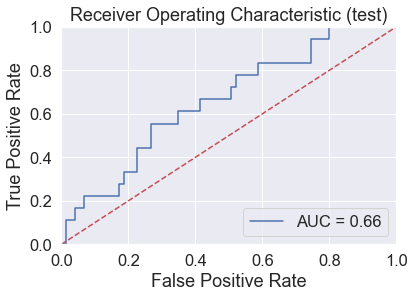


Accuracy in train set (%): 97.13
Accuracy in test set (%): 70.97

=====Train set=====
[[219   7]
 [  1  52]]

Sensivity (%): 98.11
Specificity (%): 96.89999999999999
Precision (%): 88.14
NPV (%): 99.55000000000001

=====Test set=====
[[61 14]
 [13  5]]

Sensivity (%): 27.78
Specificity (%): 81.33
Precision (%): 26.32
NPV (%): 82.43


In [82]:
y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

evaluate_model(y_train, y_pred_train, y_test, y_pred_test)